
# Lab 1 — Evaluation 101 (Regression + Classification + Human vs Metrics)

**Duration:** ~2 hours  
**GPU:** Optional (CPU is fine)

## Why this lab?
In ML projects, **evaluation** is how we decide if a model is useful, safe, and ready for real users. This lab makes evaluation **practical**:
- We’ll **define** evaluation in the context of a real lifecycle (data → model → metrics → decisions).
- We’ll **measure** both regression and classification performance, and discuss when each metric is appropriate.
- We’ll **tune thresholds** to reflect business trade‑offs (precision vs recall).
- We’ll **compare** automatic metrics with a lightweight **human evaluation** rubric—because numbers aren’t the whole story.

## Core ideas to internalize
- **No single metric suffices.** Use a **metric suite** and check **plots** (residuals, PR/ROC).
- **Data leakage** can inflate metrics—avoid peeking at test data (features derived from future, target leaks, global normalizations, etc.).
- **Distribution shift** (train ↔ prod) breaks assumptions; log & monitor post‑deployment.
- **Costs matter.** Tune decisions (e.g., 0.5 threshold) to minimize *your* error costs, not a generic benchmark.
- **Human + automatic**: combine to catch nuance (fairness, context, readability).

## Mini checklist (use it every time)
- [ ] Fix random seeds; deterministic split.  
- [ ] Train/Validation/Test separation (this lab: simple train/test; in production: add validation & cross‑validation).  
- [ ] Compare at least two baselines.  
- [ ] Inspect **both** scalar metrics and **diagnostic plots**.  
- [ ] If classification is imbalanced → prefer **PR‑AUC** and **threshold tuning**.  
- [ ] If using probabilities in production → check **calibration** (stretch goal).

> **How to run:** Execute cells **top → bottom**. Re-run sections freely.



## 0. Environment setup — what & why
We install dependable, widely used libraries:  
- `numpy`, `pandas` for data work.  
- `scikit-learn` for models and metrics.  
- `matplotlib` for simple, readable plots.  
- `ipywidgets` for a small **human evaluation** interaction.

Re-run this if the Colab runtime resets.


In [1]:

%%bash
python -V
pip -q install --upgrade pip
pip -q install numpy pandas scikit-learn matplotlib ipywidgets


Python 3.12.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.5 MB/s eta 0:00:00



Enable interactive widgets so we can collect mini human-eval scores inline.


In [2]:

from IPython.display import display
import ipywidgets as widgets
print("ipywidgets ready")


ipywidgets ready



## 1. Imports & utilities
We collect all imports and helper functions here to keep later sections clean:
- Reproducibility via seeds.
- Small plotting helpers to visualize **residuals**, **ROC/PR curves**, and **threshold sweeps**.
- A convenience **RMSE** function and a **confusion matrix** formatter.


In [3]:

import math, random, textwrap, statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import fetch_california_housing, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(42)
random.seed(42)

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def plot_hist(values, title, xlabel):
    plt.figure()
    plt.hist(values, bins=30)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.show()

def plot_scatter(x, y, title, xlabel, ylabel):
    plt.figure()
    plt.scatter(x, y, s=10)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_line(x, y, title, xlabel, ylabel):
    plt.figure()
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_curves(fpr, tpr, roc_auc, precision, recall, ap):
    # ROC
    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(f"ROC curve (AUC={roc_auc:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    # PR
    plt.figure()
    plt.plot(recall, precision)
    plt.title(f"Precision-Recall curve (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

def confusion_matrix_table(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df = pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"])
    return df



## 2. Evaluation theory — concepts we will apply
**Regression metrics**
- **MAE**: Average absolute error; robust when you care equally about all errors.
- **MSE/RMSE**: Square error penalizes large mistakes (outliers hurt more). RMSE is in target units.
- **R²**: Fraction of variance explained by the model (can be negative if the model is worse than predicting the mean).

**Classification metrics**
- **Accuracy** can mislead under **imbalance**.
- **Precision/Recall/F1** describe different trade-offs (false positives vs false negatives).
- **ROC‑AUC** is threshold-free separability.
- **PR‑AUC (AP)** is more informative when positives are rare.
- **Threshold tuning** lets you pick an operating point that aligns with business costs.

**Human vs Metrics**
- Humans judge **nuance** and **context**; metrics are **fast** and **repeatable**. Use both.



## 3. Regression — dataset & target
We use **California Housing** (tabular, well-known) to predict **median house value**.  
Why this dataset?
- Clean, moderate size → runs quickly on Colab.
- Intuitive target → makes error interpretation straightforward.

We’ll compare a **linear** baseline vs a **nonlinear** ensemble:
- **LinearRegression**: fast, interpretable baseline.
- **RandomForestRegressor**: handles nonlinearity & interactions out-of-the-box.


In [4]:

cal = fetch_california_housing(as_frame=True)
df_reg = cal.frame.copy()
df_reg.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



### Train/test split & model training
- We do a simple **80/20 split** (for production you’d also add validation and/or cross‑validation).
- Train both models and compute a **metric suite**: MAE, MSE, RMSE, R².
- Goal: establish a **strong baseline** and a **nonlinear contender**.


In [5]:

X = df_reg.drop(columns=["MedHouseVal"])
y = df_reg["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg = Pipeline([("model", LinearRegression())])
rfreg  = Pipeline([("model", RandomForestRegressor(
    n_estimators=200, random_state=42, n_jobs=-1, max_depth=None))])

for name, model in [("LinearRegression", linreg), ("RandomForestRegressor", rfreg)]:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    metrics = {
        "MAE": mean_absolute_error(y_test, pred),
        "MSE": mean_squared_error(y_test, pred),
        "RMSE": rmse(y_test, pred),
        "R2": r2_score(y_test, pred),
    }
    print(f"\n{name} metrics:")
    for k,v in metrics.items():
        print(f"  {k:>4}: {v:.4f}")



LinearRegression metrics:
   MAE: 0.5332
   MSE: 0.5559
  RMSE: 0.7456
    R2: 0.5758

RandomForestRegressor metrics:
   MAE: 0.3268
   MSE: 0.2540
  RMSE: 0.5040
    R2: 0.8062



### Residual diagnostics
- **Residuals** (y - ŷ) should look roughly **zero‑centered** with no strong patterns.
- Patterns can indicate **misspecification** (e.g., nonlinearity, heteroscedasticity).
We’ll inspect distribution and **residuals vs predictions** for the **better** model.


Residual analysis for: RandomForestRegressor


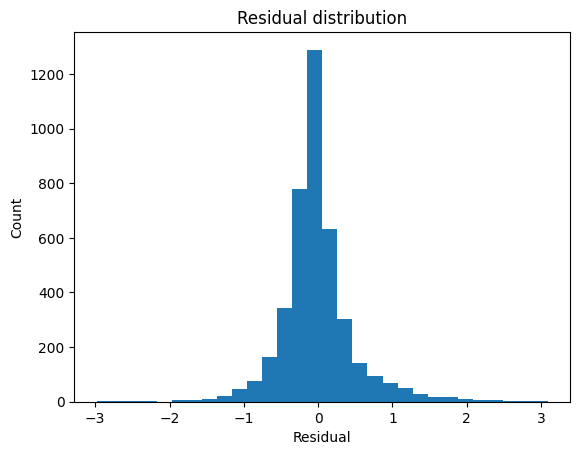

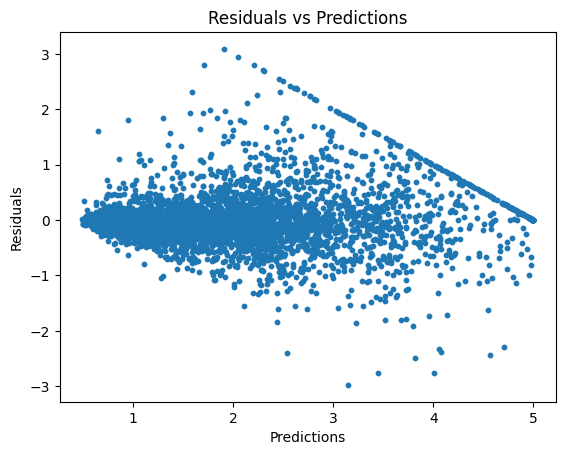

In [6]:

# Fit both again for clarity
linreg.fit(X_train, y_train); pred_lin = linreg.predict(X_test)
rfreg.fit(X_train, y_train);    pred_rf  = rfreg.predict(X_test)

mae_lin, mae_rf = mean_absolute_error(y_test, pred_lin), mean_absolute_error(y_test, pred_rf)
best_pred = pred_rf if mae_rf < mae_lin else pred_lin
best_name = "RandomForestRegressor" if mae_rf < mae_lin else "LinearRegression"
residuals = y_test.values - best_pred

print(f"Residual analysis for: {best_name}")
plot_hist(residuals, "Residual distribution", "Residual")
plot_scatter(best_pred, residuals, "Residuals vs Predictions", "Predictions", "Residuals")



## 4. Classification — imbalance, metrics & thresholds
We simulate a **binary classification** task with **class imbalance** (~10% positives).  
Why? Many real problems (fraud, defects) have minority positives; **accuracy** alone is misleading.

We compare:
- **LogisticRegression** (with standardization) — strong linear baseline.
- **RandomForestClassifier** — robust nonlinear baseline.

We’ll compute: **Accuracy, Precision, Recall, F1, ROC‑AUC, PR‑AUC (AP)**  
Then we’ll **choose the best model by PR‑AUC** and **tune its decision threshold** to maximize F1.


In [7]:

from sklearn.metrics import roc_curve, precision_recall_curve

X_cls, y_cls = make_classification(
    n_samples=6000, n_features=20, n_informative=8, n_redundant=4,
    weights=[0.90, 0.10], random_state=42, flip_y=0.01, class_sep=1.0
)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

logreg = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=200, n_jobs=None))])
rfclf  = Pipeline([("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))])

models = {"LogisticRegression": logreg, "RandomForestClassifier": rfclf}
for name, model in models.items():
    model.fit(Xc_train, yc_train)
    prob = model.predict_proba(Xc_test)[:,1]
    pred = (prob >= 0.5).astype(int)
    acc = accuracy_score(yc_test, pred)
    prec = precision_score(yc_test, pred)
    rec = recall_score(yc_test, pred)
    f1 = f1_score(yc_test, pred)
    roc = roc_auc_score(yc_test, prob)
    ap  = average_precision_score(yc_test, prob)
    print(f"\n{name} @0.5 threshold:")
    print(f"  Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(f"  ROC-AUC: {roc:.4f} | PR-AUC (AP): {ap:.4f}")



LogisticRegression @0.5 threshold:
  Accuracy: 0.8950 | Precision: 0.4000 | Recall: 0.0160 | F1: 0.0308
  ROC-AUC: 0.7481 | PR-AUC (AP): 0.3525

RandomForestClassifier @0.5 threshold:
  Accuracy: 0.9400 | Precision: 0.9649 | Recall: 0.4400 | F1: 0.6044
  ROC-AUC: 0.9527 | PR-AUC (AP): 0.8337



### ROC & PR curves
- **ROC** shows TPR vs FPR; good for overall separability.
- **PR** focuses on positive class performance; more informative under imbalance.
We’ll plot both for the **model with highest PR‑AUC**.


Best by PR-AUC: RandomForestClassifier


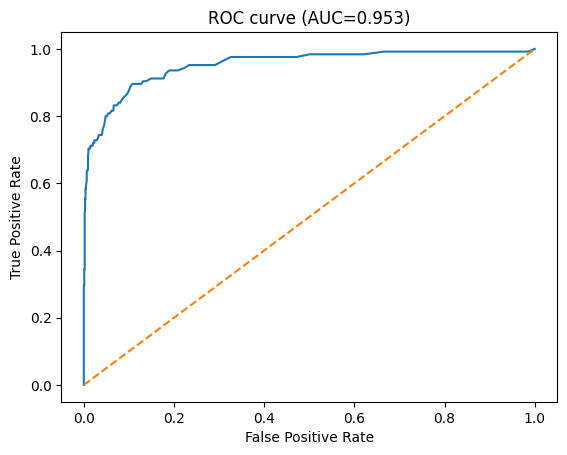

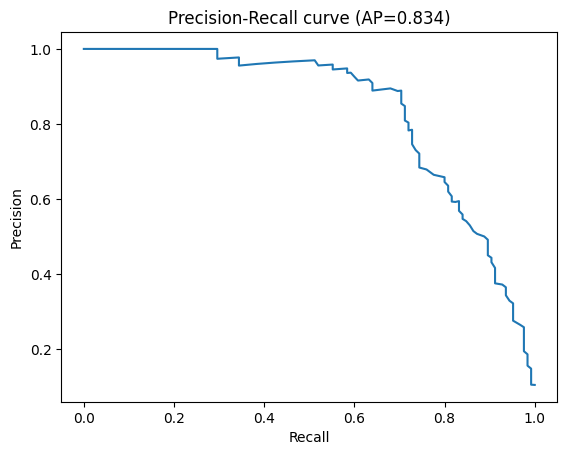

In [8]:

scores = {}
for name, model in models.items():
    prob = model.predict_proba(Xc_test)[:,1]
    ap  = average_precision_score(yc_test, prob)
    scores[name] = (ap, prob)

best_name = max(scores, key=lambda k: scores[k][0])
best_prob = scores[best_name][1]

fpr, tpr, _ = roc_curve(yc_test, best_prob)
precision, recall, _ = precision_recall_curve(yc_test, best_prob)
roc_auc = roc_auc_score(yc_test, best_prob)
ap = average_precision_score(yc_test, best_prob)

print(f"Best by PR-AUC: {best_name}")
plot_curves(fpr, tpr, roc_auc, precision, recall, ap)



### Threshold tuning
The default 0.5 cutoff may not align with your **business cost** of false positives/negatives.  
We sweep thresholds and pick the one that **maximizes F1** (balanced errors).  
You can adapt this to optimize custom **cost** functions in production.


Best threshold by F1: 0.30, F1=0.7753


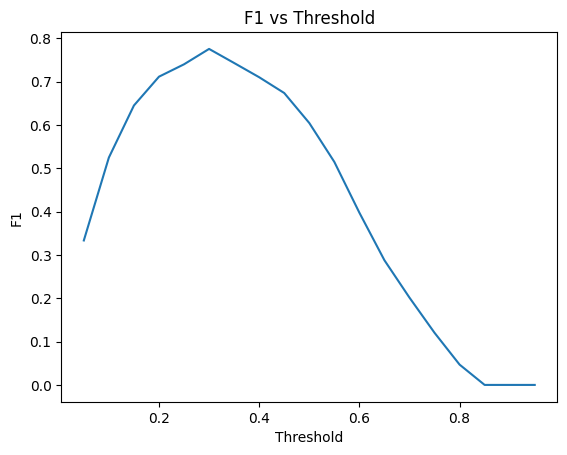


Confusion matrix @0.5:


,Pred 0,Pred 1
True 0,1073,2
True 1,70,55



Confusion matrix @best_t:


,Pred 0,Pred 1
True 0,1061,14
True 1,37,88


In [9]:

thresholds = np.linspace(0.05, 0.95, 19)
from sklearn.metrics import f1_score
f1s = []
for t in thresholds:
    pred = (best_prob >= t).astype(int)
    f1s.append(f1_score(yc_test, pred))

import numpy as np
best_t = thresholds[int(np.argmax(f1s))]
print(f"Best threshold by F1: {best_t:.2f}, F1={max(f1s):.4f}")

plot_line(thresholds, f1s, "F1 vs Threshold", "Threshold", "F1")

# Confusion matrices at 0.5 and best_t
from IPython.display import display
pred_default = (best_prob >= 0.5).astype(int)
pred_best = (best_prob >= best_t).astype(int)

print("\nConfusion matrix @0.5:")
display(confusion_matrix_table(yc_test, pred_default))

print("\nConfusion matrix @best_t:")
display(confusion_matrix_table(yc_test, pred_best))



## 5. Human evaluation vs Metrics
Automatic metrics can’t capture everything (e.g., *is this explanation understandable?*).  
We’ll:
1) **Select borderline items** where the model is least confident (proba ≈ threshold).  
2) **Collect human ratings** (1–5).  
3) **Correlate** human ratings with model confidence to see alignment/mismatch.

Now, please note that you might not be able to completely comprehend the parameters based on which we should be evaluating the model and that is alright, the next section will teach us how to get required information from our models which will ultimately help us in better decision-making.


In [10]:

# Select borderline cases from best model (probability near best_t)
idx = np.argsort(np.abs(best_prob - best_t))[:8]  # 8 closest to threshold
border_df = pd.DataFrame({
    "proba": best_prob[idx],
    "true": yc_test[idx]
}).reset_index(drop=True)
border_df


,proba,true
0,0.303333,0
1,0.303333,0
2,0.303333,0
3,0.306667,1
4,0.293333,0
5,0.310000,1
6,0.310000,1
7,0.290000,0



### Collect human ratings
Use sliders to rate each item:  
**1 = clearly wrong**, **3 = borderline**, **5 = clearly correct**.  
This is a tiny proxy for human eval workflows (rubrics, double-rating, reconciliation).


In [11]:

ratings = []

boxes = []
for i in range(len(border_df)):
    b = widgets.IntSlider(description=f"Item {i+1}", min=1, max=5, value=3)
    boxes.append(b)

submit = widgets.Button(description="Submit Ratings", button_style="success")

out = widgets.Output()

def on_submit(_):
    with out:
        out.clear_output()
        r = [b.value for b in boxes]
        print("Thanks! Ratings captured:", r)
        global ratings
        ratings = r

display(widgets.VBox(boxes + [submit, out]))
submit.on_click(on_submit)



### Compare human vs model confidence
We compute the correlation between your **ratings** and the model’s **distance from threshold**.  
- If correlation is high → human judgments align with model confidence.  
- If low/negative → investigate calibration, data quality, or task ambiguity.


In [12]:

# Compare rubric vs model "confidence" (distance from threshold) and outcome
if 'ratings' in globals() and ratings:
    compare = border_df.copy()
    compare["rating"] = ratings
    compare["dist_from_t"] = (compare["proba"] - best_t).abs()
    corr = compare[["rating","dist_from_t"]].corr().iloc[0,1]
    print(f"Correlation between human rating and model confidence: {corr:.3f}")
    display(compare)
    plot_scatter(compare["dist_from_t"], compare["rating"], "Human rating vs Model confidence", "Distance from threshold", "Rating")
else:
    print("⚠️ Please provide ratings above, then re-run this cell.")


⚠️ Please provide ratings above, then re-run this cell.



## 5A. Human evaluation with **Tabular + SHAP** (interpretable features)

In Section 5, we noted that human ratings need *interpretable* context. For tabular data, we can use **SHAP** (SHapley values) to
explain which features most influenced a prediction and in **which direction**.

We’ll use the classic **Breast Cancer** dataset (features have human-readable names).  
> *Illustrative only — not medical advice.*

**Flow**
1) Train a **RandomForestClassifier** on the dataset.  
2) Identify **borderline** predictions (probability ≈ 0.5).  
3) Compute **per-instance SHAP values** and show the **top contributors**.  
4) You rate **plausibility** (1–5): *1 = implausible*, *3 = unsure*, *5 = plausible*.  
5) We compare your ratings with **model confidence** (|proba − 0.5|).


### Install SHAP (one-time)

In [13]:

%%bash
pip -q install shap



### Train a classifier on an interpretable tabular dataset
We use the **Breast Cancer** dataset (features like `mean radius`, `mean texture`, …).  
We keep the model simple (Random Forest) for fast training and SHAP compatibility.


In [14]:

import numpy as np, pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, roc_auc_score, precision_recall_curve, roc_curve
)

bc = load_breast_cancer()
X = pd.DataFrame(bc.data, columns=bc.feature_names)
y = pd.Series(bc.target)  # 0 = malignant, 1 = benign
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(
    X, y, test_size=0.3, random_state=7, stratify=y
)

rf_bc = RandomForestClassifier(n_estimators=400, random_state=7, n_jobs=-1)
rf_bc.fit(X_train_bc, y_train_bc)
proba_bc = rf_bc.predict_proba(X_test_bc)[:, 1]  # P(benign)
pred_bc = (proba_bc >= 0.5).astype(int)

print("Test metrics:")
print("  Accuracy:", round(accuracy_score(y_test_bc, pred_bc), 3))
print("  Precision:", round(precision_score(y_test_bc, pred_bc), 3))
print("  Recall:", round(recall_score(y_test_bc, pred_bc), 3))
print("  F1:", round(f1_score(y_test_bc, pred_bc), 3))
print("  ROC-AUC:", round(roc_auc_score(y_test_bc, proba_bc), 3))
print("  PR-AUC (AP):", round(average_precision_score(y_test_bc, proba_bc), 3))


Test metrics:
  Accuracy: 0.971
  Precision: 0.981
  Recall: 0.972
  F1: 0.977
  ROC-AUC: 0.997
  PR-AUC (AP): 0.998



### Pick borderline items
We surface test samples with **probabilities closest to 0.5** (least confident).  
You’ll see **feature contributions** (SHAP) for these items.


In [15]:

import numpy as np, pandas as pd

threshold_bc = 0.5
idx_bc = np.argsort(np.abs(proba_bc - threshold_bc))[:6]  # 6 closest to 0.5
border_bc = pd.DataFrame({
    "proba_benign": proba_bc[idx_bc],
    "pred": pred_bc[idx_bc],
    "true": y_test_bc.iloc[idx_bc].values
}).reset_index(drop=True)

border_features = X_test_bc.iloc[idx_bc].reset_index(drop=True)
display(border_bc)


,proba_benign,pred,true
0,0.5025,1,1
1,0.5150,1,0
2,0.5200,1,0
3,0.4750,0,0
4,0.5475,1,1
5,0.4525,0,1



### Compute SHAP values
**SHAP** estimates each feature’s contribution to pushing the prediction toward **benign (1)** vs **malignant (0)**.  
We’ll show **Top-5** absolute contributors per instance, including:
- **feature name**
- **feature value**
- **SHAP value** (positive → pushes toward **benign**, negative → toward **malignant**)


In [16]:

import shap
import numpy as np, pandas as pd

explainer = shap.TreeExplainer(rf_bc)
# shap_values is a list for classification: [class0, class1]
sv = explainer.shap_values(border_features)
sv_class1 = sv[1]  # contributions toward class 1 (benign)

def instance_top_k_table(i, k=5):
    vals = sv_class1[i]
    feats = border_features.columns
    abs_order = np.argsort(np.abs(vals))[::-1][:k]
    df = pd.DataFrame({
        "feature": feats[abs_order],
        "feature_value": border_features.iloc[i, abs_order].values,
        "shap_value_toward_benign": vals[abs_order]
    })
    return df

top_tables = [instance_top_k_table(i) for i in range(len(border_bc))]
for i, tbl in enumerate(top_tables, 1):
    print(f"\n==== Instance {i} (pred={border_bc.loc[i-1,'pred']}, true={border_bc.loc[i-1,'true']}, proba_benign={border_bc.loc[i-1,'proba_benign']:.2f}) ====")
    display(tbl)



==== Instance 1 (pred=1, true=1, proba_benign=0.50) ====


,feature,feature_value,shap_value_toward_benign
0,mean texture,16.54,0.001026
1,mean radius,14.42,-0.001026



==== Instance 2 (pred=1, true=0, proba_benign=0.52) ====


,feature,feature_value,shap_value_toward_benign
0,mean texture,25.20,-0.014932
1,mean radius,14.99,0.014932



==== Instance 3 (pred=1, true=0, proba_benign=0.52) ====


,feature,feature_value,shap_value_toward_benign
0,mean texture,22.55,0.006712
1,mean radius,14.27,-0.006712



==== Instance 4 (pred=0, true=0, proba_benign=0.47) ====


,feature,feature_value,shap_value_toward_benign
0,mean radius,15.13,0.016732
1,mean texture,29.81,-0.016732



==== Instance 5 (pred=1, true=1, proba_benign=0.55) ====


,feature,feature_value,shap_value_toward_benign
0,mean texture,22.11,-0.002117
1,mean radius,14.99,0.002117



==== Instance 6 (pred=0, true=1, proba_benign=0.45) ====


,feature,feature_value,shap_value_toward_benign
0,mean radius,14.26,0.004548
1,mean texture,19.65,-0.004548



### Human plausibility ratings with SHAP context (what & how)
Use the **Top-5 feature contribution tables** above to rate **plausibility** of each prediction:

- **Interpretation guide (non-medical):**
  - Larger **size-related** features (e.g., `mean radius`, `mean area`, `worst radius/area/perimeter`) often associate with **malignancy**.
  - Certain **texture/concavity**–related features increasing may also indicate malignancy.
  - If SHAP shows **large positive** values for features that intuitively suggest *malignancy*, yet the model predicts **benign**, that’s **implausible**.

**Rubric (1–5):**
- **1** = Prediction & top features feel **implausible** together  
- **3** = **Uncertain** / mixed signals  
- **5** = Prediction & SHAP attributions feel **plausible**

> You don’t need domain expertise — focus on **consistency** between predicted class and the **direction** of influential features.


In [17]:

import ipywidgets as widgets
from IPython.display import display

ratings_bc = []
sliders_bc = [widgets.IntSlider(description=f"Item {i+1}", min=1, max=5, value=3) for i in range(len(border_bc))]
submit_bc = widgets.Button(description="Submit SHAP Ratings", button_style="success")
out_bc = widgets.Output()

def on_submit_bc(_):
    with out_bc:
        out_bc.clear_output()
        r = [int(b.value) for b in sliders_bc]
        print("SHAP Ratings:", r)
        global ratings_bc
        ratings_bc = r

display(widgets.VBox(sliders_bc + [submit_bc, out_bc]))
submit_bc.on_click(on_submit_bc)



### Compare ratings vs model confidence
We compute correlation between your **ratings** and the model’s **confidence** (`|proba−0.5|`).  
Higher correlation suggests your plausibility judgments align with when the model is more certain.


Correlation (rating vs confidence): 0.348


,proba_benign,pred,true,rating,confidence
0,0.5025,1,1,3,0.0025
1,0.5150,1,0,4,0.0150
2,0.5200,1,0,3,0.0200
3,0.4750,0,0,2,0.0250
4,0.5475,1,1,3,0.0475
5,0.4525,0,1,5,0.0475


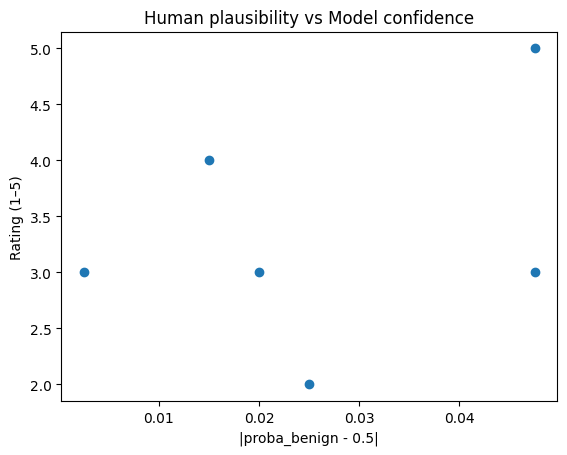

In [19]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

if 'ratings_bc' in globals() and ratings_bc:
    comp = border_bc.copy()
    comp["rating"] = ratings_bc
    comp["confidence"] = (comp["proba_benign"] - 0.5).abs()
    print("Correlation (rating vs confidence):", round(comp[["rating","confidence"]].corr().iloc[0,1], 3))
    display(comp)

    plt.figure()
    plt.scatter(comp["confidence"], comp["rating"])
    plt.title("Human plausibility vs Model confidence")
    plt.xlabel("|proba_benign - 0.5|")
    plt.ylabel("Rating (1–5)")
    plt.show()
else:
    print("⚠️ Please submit SHAP ratings above, then re-run this cell.")



**Reflection**
- Did any instance look **implausible** despite high confidence? That’s a candidate for **error analysis**:
  - Check data quality, feature engineering, or try a different model.
- For plausible-but-wrong cases, consider **threshold adjustment** or **cost-sensitive** training.
- In production, combine **periodic human spot-checks** + **monitoring** (metrics, drift, calibration).




## 6. Summary & reflection
- **Regression:** Compare MAE/MSE/RMSE/R²; confirm residuals look healthy.
- **Classification:** Prefer PR‑AUC under imbalance; pick a **threshold** that matches your business costs.
- **Human vs Metrics:** Use both. Metrics guide, humans validate nuance.

### Reflection prompts
1. When would you **prefer MAE** over RMSE and why?  
2. In your classification task, which matters more—**precision** or **recall**? How would that change your threshold?  
3. How correlated were your **human ratings** with model confidence? What does that imply?

### Stretch goals
- Add **cross‑validation**; inspect metric variance.  
- Try **probability calibration** (Platt/Isotonic) and re‑tune the threshold.  
- Swap in **XGBoost/LightGBM** and compare.
